##### Creating a **BIRD CALL DETECTION SYSTEM** involves converting audio files into WAV format, segmenting them, and transforming segments into spectrograms.

- ##### These spectrograms, representing time-frequency information, serve as input to a Convolutional Neural Network (CNN).

- ##### The CNN is trained to distinguish between bird calls and non-bird sounds. Data augmentation enhances training, and the model's performance is evaluated using metrics like accuracy.

- ##### Once trained effectively, the model can identify bird calls in audio recordings, making it a valuable tool for ecological and ornithological research.


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import tensorflow_io as tfio
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)
import os

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

2023-11-08 00:38:10.859058: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 00:38:11.929999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Getting the path of a single file using OS Module**


In [2]:
capuchin_file = os.path.join("data", "Parsed_Capuchinbird_Clips", "XC3776-0.wav")
not_capuchin_file = os.path.join(
    "data", "Parsed_Not_Capuchinbird_Clips", "afternoon-birds-song-in-forest-0.wav"
)

**Defining a Function to convert the Audio Clips into WAV Format.**

This function, `load_wav_16k_mono(filename)`, takes a WAV audio file as input and performs several operations using TensorFlow and TensorFlow I/O (TFIO) to prepare the audio for further processing. Here's a brief description of what the code does:

1. `file_contents = tf.io.read_file(filename)`: Reads the content of the input WAV file.

2. `wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)`: Decodes the WAV file, converting it into a TensorFlow tensor. It ensures that the audio is mono (single-channel) by specifying `desired_channels=1`.

3. `wav = tf.squeeze(wav, axis=-1)`: Removes any trailing axis, ensuring that the audio tensor is one-dimensional (mono audio).

4. `sample_rate = tf.cast(sample_rate, dtype=tf.int64)`: Converts the sample rate to a TensorFlow integer data type.

5. `wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)`: Resamples the audio signal from its original sample rate (typically 44100 Hz) to 16000 Hz. Resampling adjusts the speed of the audio without changing its pitch, and in this case, it standardizes the sample rate for consistency.

6. `return wav`: Returns the processed audio tensor with a sample rate of 16000 Hz, making it suitable for further analysis or input into machine learning models.

**In summary, this function loads a WAV file, ensures it is mono, standardizes the sample rate to 16000 Hz, and returns the processed audio data as a TensorFlow tensor for subsequent processing or analysis, such as feeding into a machine learning model for bird call detection.**


In [3]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

**Converting all the audio files into a WAV format using the load_wav_16k_mono Function**


In [4]:
wave = load_wav_16k_mono(capuchin_file)
nwave = load_wav_16k_mono(not_capuchin_file)

2023-11-08 00:38:13.606929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 00:38:13.640695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-08 00:38:13.641011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

**Plotting the audio file into its WAV Format**


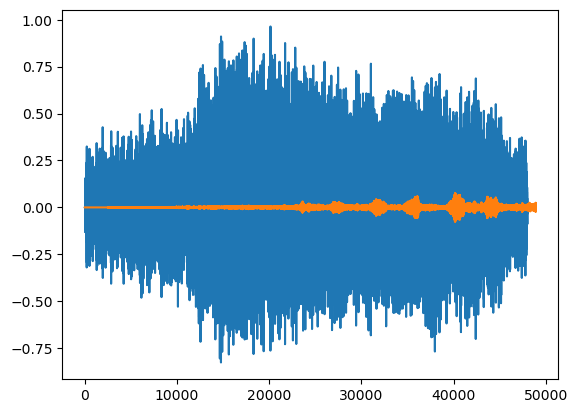

In [5]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [6]:
pos = os.path.join("data", "Parsed_Capuchinbird_Clips")
neg = os.path.join("data", "Parsed_Not_Capuchinbird_Clips")

**tf.data.Dataset.list_files** function creates two TensorFlow datasets, one for positive examples and one for negative examples, which are audio files in the `.wav` format.

- `positive = tf.data.Dataset.list_files(pos+"/*.wav")`: This line creates a TensorFlow dataset (`positive`) by listing all the `.wav` files within a directory specified by the `pos` variable. The `pos` variable represent the path to a directory containing positive examples.

- `negative = tf.data.Dataset.list_files(neg+"/*.wav")`: This line creates another TensorFlow dataset (`negative`) by listing all the `.wav` files within a directory specified by the `neg` variable. The `neg` variable represent the path to a directory containing negative examples.


In [7]:
positive = tf.data.Dataset.list_files(pos + "/*.wav")
negative = tf.data.Dataset.list_files(neg + "/*.wav")

In [8]:
positive.as_numpy_iterator().next()
len(negative)

593

The code creates TensorFlow datasets for positive and negative examples and combines them into a single dataset for binary classification tasks.

- `positives` and `negatives` Datasets:

  - `positives` is created by zipping the `positive` dataset (containing paths to positive examples) with a dataset of ones (using `tf.data.Dataset.from_tensor_slices(tf.ones(len(positive)))`). This associates each positive example with the label 1.

  - Similarly, `negatives` is created by zipping the `negative` dataset (containing paths to negative examples) with a dataset of zeros, associating each negative example with the label 0.

- Combining Positive and Negative Datasets:

  - The `data` dataset is created by concatenating `positives` and `negatives`. This combines the positive and negative examples into a single dataset for binary classification, where each example is associated with its corresponding label (1 for positive, 0 for negative).


In [9]:
positives = tf.data.Dataset.zip(
    (positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(positive))))
)
negatives = tf.data.Dataset.zip(
    (negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(negative))))
)
data = positives.concatenate(negatives)

**The code iterates over audio files in a directory and calculates the length of each audio file in terms of the number of samples.**

1. `lengths` List:

   - An empty list called `lengths` is initialized. This list will be used to store the lengths (number of samples) of the audio files.

2. Iterating Over Audio Files:

   - The code uses a `for` loop to iterate through the files in the directory specified by `"data/Parsed_Capuchinbird_Clips"` by using the `os.listdir` function to list the files in the directory.

3. Loading and Calculating Length:

   - For each file in the directory, the code loads the audio data using the `load_wav_16k_mono` function. The audio data is expected to be in mono format at a 16 kHz sample rate.

   - The length of the audio is determined by calculating the number of samples in the waveform, and this length is appended to the `lengths` list.

The `lengths` list will contain the lengths (in samples) of all the audio files in the specified directory.


In [10]:
lengths = []
for file in os.listdir(os.path.join("data", "Parsed_Capuchinbird_Clips")):
    tensor_wave = load_wav_16k_mono(
        os.path.join("data", "Parsed_Capuchinbird_Clips", file)
    )
    lengths.append(len(tensor_wave))

In [11]:
def eda(length: list) -> float:
    mean = tf.reduce_mean(length)
    maximum = tf.reduce_max(length)
    minimum = tf.reduce_min(length)
    print(
        f"Minimum length of the clip: {minimum/16000} Sec\nMean Length of the clip: {mean/16000} Sec\nMaximum Length of the clip: {maximum/16000} Sec"
    )


eda(lengths)

Minimum length of the clip: 2.0 Sec
Mean Length of the clip: 3.38475 Sec
Maximum Length of the clip: 5.0 Sec


# Audio Data Preprocessing with TensorFlow

The `preprocess` function is a versatile tool designed to preprocess audio data for various machine learning or deep learning tasks. It accepts a file path and a corresponding label and applies a series of transformations to prepare the audio data for model input.

## Input Parameters

- `file_path`: A string representing the file path to the audio file.
- `label`: A label associated with the audio data (e.g., a class label).

## Preprocessing Steps

1. **Loading and Truncating the Audio:**

   - Load the audio data using the `load_wav_16k_mono` function, assuming a mono format at a 16 kHz sample rate.
   - Truncate the audio to a maximum length of 48000 samples.

2. **Zero Padding:**

   - If the audio data is shorter than 48000 samples, zero padding is applied to ensure a consistent length of 48000 samples.

3. **Spectrogram Calculation:**

   - Compute the Short-Time Fourier Transform (STFT) of the audio waveform using TensorFlow's `tf.signal.stft` function, resulting in a spectrogram representation.
   - Calculate the magnitude of the spectrogram using `tf.abs` to capture frequency domain information.

4. **Expanding Dimensions:**
   - Add an extra dimension to the spectrogram using `tf.expand_dims`. This is often necessary to match the input requirements of neural network models.

## Output

The `preprocess` function returns a tuple containing the preprocessed audio data (the spectrogram) and its associated label.


In [12]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

# Visualizing Spectrogram of a Random Positive Example

This code snippet demonstrates how to visualize the spectrogram of a randomly selected positive example using TensorFlow and Matplotlib. It consists of the following steps:

1. **Selecting a Random Positive Example:**

   - A random positive example is selected from the `positives` dataset. The `shuffle` method is used to shuffle the dataset with a buffer size of 10,000, ensuring random selection.
   - The selected example's file path and label are retrieved using `.as_numpy_iterator().next()`.

2. **Audio Preprocessing:**

   - The `preprocess` function is applied to the selected example, which loads and preprocesses the audio.
   - The resulting spectrogram and its associated label are obtained.

3. **Plotting the Spectrogram:**

   - A Matplotlib figure is created with a large size (30x20) to display the spectrogram.
   - The spectrogram is transposed to ensure proper visualization with `tf.transpose(spectrogram)`.
   - The spectrogram is displayed using `plt.imshow`.

4. **Displaying the Plot:**
   - The plot is shown using `plt.show()`, allowing you to view the spectrogram of the selected positive example.


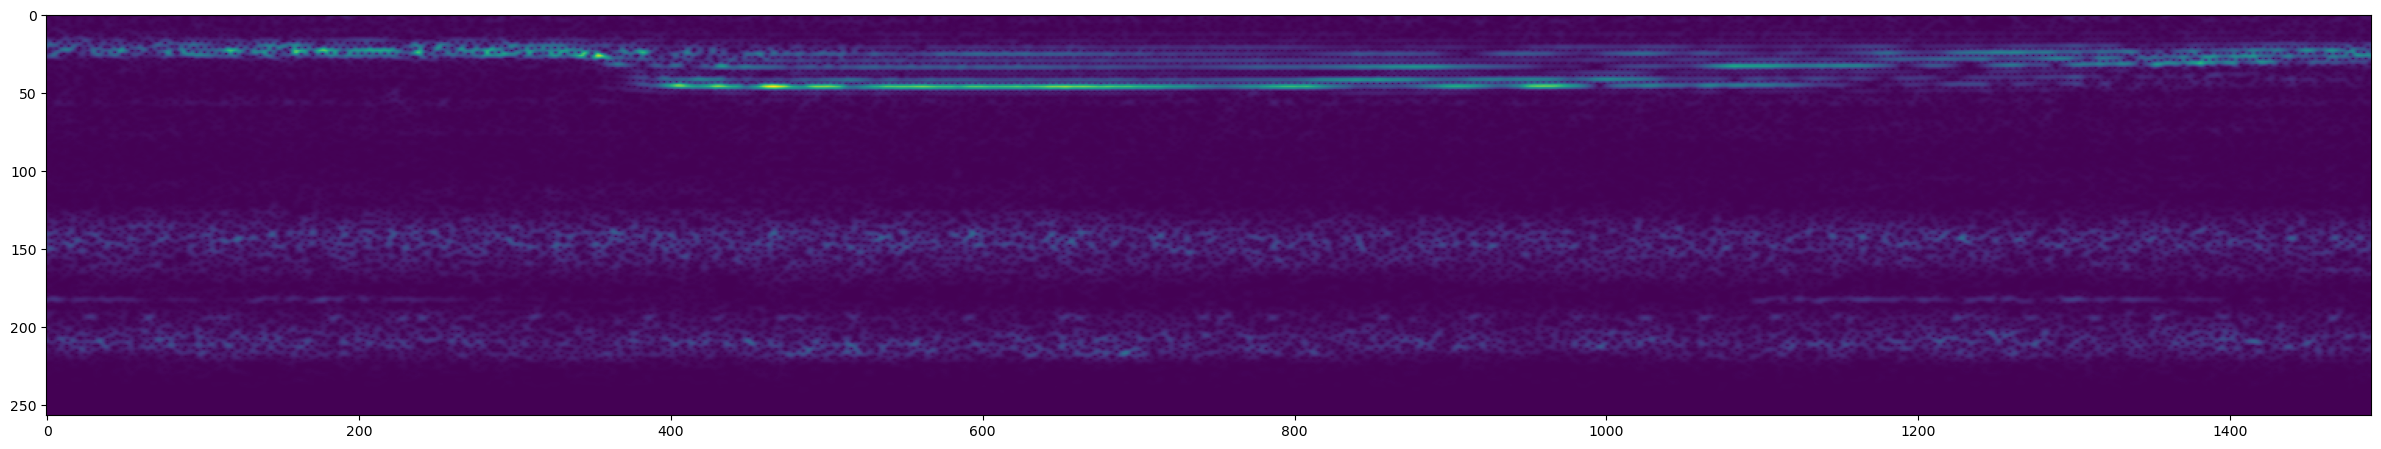

In [13]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Audio Data Preprocessing Pipeline

This code snippet outlines a series of data preprocessing steps for audio data using TensorFlow's Dataset API. The goal is to prepare the data for training machine learning or deep learning models.

1. **Mapping the `preprocess` Function:**
   - The `data` is mapped through the `preprocess` function. This function loads and preprocesses each audio example, generating spectrograms.
2. **Caching Data:**

   - The `data` is cached to improve data loading efficiency during subsequent iterations. This is especially beneficial for large datasets.

3. **Shuffling Data:**

   - The dataset is shuffled with a buffer size of 1000, ensuring randomization of the data. Shuffling is a common practice to prevent the model from learning the order of examples.

4. **Batching Data:**

   - The data is grouped into batches of 16 examples. Batching is essential for training the model in mini-batches, improving training efficiency.

5. **Prefetching Data:**
   - The `data` is prefetched with a buffer size of 8. Prefetching allows for asynchronous data loading during training, minimizing the idle time of the model.

This preprocessing pipeline ensures that the audio data is properly formatted, randomized, and efficiently loaded, making it suitable for training machine learning models. The steps are designed to enhance training performance and generalization.


In [14]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [15]:
train = data.take(36)
test = data.skip(36).take(15)

# Testing One Batch


In [16]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten

# Memory-Efficient Convolutional Neural Network

The following code defines a memory-efficient Convolutional Neural Network (CNN) using TensorFlow's Keras API. This architecture is designed to reduce memory consumption while maintaining a basic CNN structure.

## Model Architecture

1. **Input Layer:**

   - Input shape: (1491, 257, 1)
   - The input data represents audio spectrograms.

2. **Convolutional Layers:**

   - Two convolutional layers with 8 filters each and a 3x3 kernel size.
   - ReLU activation functions are applied to introduce non-linearity.

3. **Flatten Layer:**

   - The Flatten layer is used to transition from the convolutional layers to the dense layers.

4. **Dense Layers:**
   - A single hidden dense layer with 64 neurons and ReLU activation.
   - This layer extracts high-level features from the flattened data.
5. **Output Layer:**
   - A single neuron output layer with sigmoid activation, suitable for binary classification tasks.

## Key Features

- Reduced model complexity: Fewer filters and neurons to save memory.
- Suitable for memory-constrained environments.
- Designed to mitigate "Out of Memory" (OOM) errors on GPUs.

This memory-efficient architecture is well-suited for scenarios where memory limitations are a concern but still provides basic CNN capabilities for tasks like binary image or audio classification.


In [18]:
model = Sequential()
model.add(Conv2D(8, (3, 3), activation="relu", input_shape=(1491, 257, 1)))
model.add(Conv2D(8, (3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [19]:
model.compile(
    "Adam",
    loss="BinaryCrossentropy",
    metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()],
)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 8)      80        
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 8)      584       
                                                                 
 flatten (Flatten)           (None, 3009688)           0         
                                                                 
 dense (Dense)               (None, 64)                192620096 
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 192620825 (734.79 MB)
Trainable params: 192620825 (734.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4


2023-11-08 00:38:32.395974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-11-08 00:38:32.534230: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-08 00:38:33.008131: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 1750357504 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 984219648/4096196608
2023-11-08 00:38:33.008172: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      2930376704
InUse:                      2934578322
MaxInUse:                   3829022866
NumAllocs:                        2371
MaxAllocSize:                894444544
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2023-11-08 00

36/36 [==============================] - 13s 247ms/step - loss: 1.6374 - recall: 0.8800 - precision: 0.8462 - val_loss: 0.1837 - val_recall: 0.9231 - val_precision: 0.9677
Epoch 2/4
36/36 [==============================] - 8s 221ms/step - loss: 0.1268 - recall: 0.9536 - precision: 0.9600 - val_loss: 0.0662 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 8s 223ms/step - loss: 0.0674 - recall: 0.9686 - precision: 0.9872 - val_loss: 0.0130 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 8s 224ms/step - loss: 0.0531 - recall: 0.9811 - precision: 0.9936 - val_loss: 0.0331 - val_recall: 1.0000 - val_precision: 1.0000


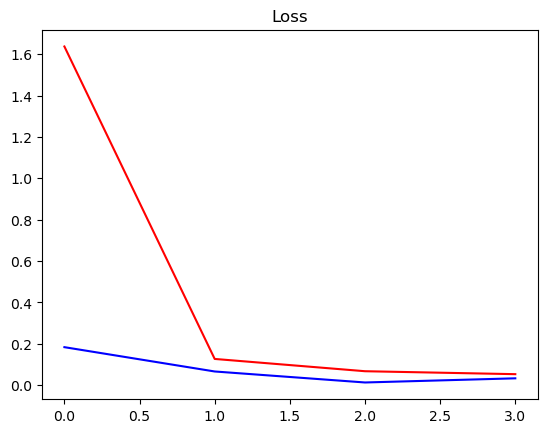

In [22]:
plt.title("Loss")
plt.plot(hist.history["loss"], "r")
plt.plot(hist.history["val_loss"], "b")
plt.show()

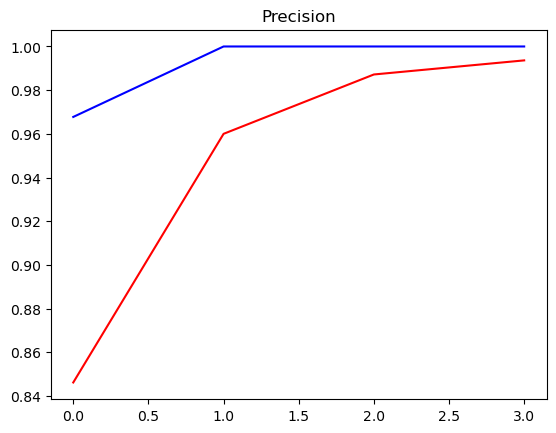

In [23]:
plt.title("Precision")
plt.plot(hist.history["precision"], "r")
plt.plot(hist.history["val_precision"], "b")
plt.show()

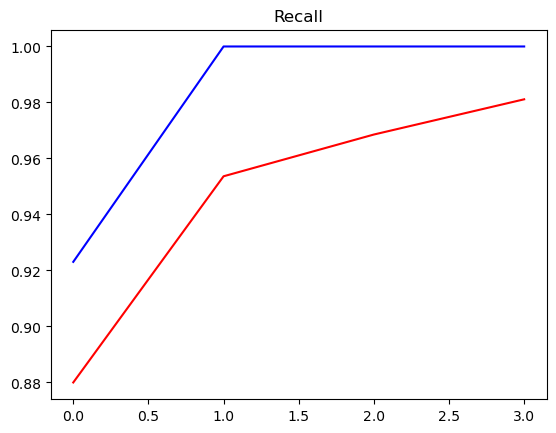

In [24]:
plt.title("Recall")
plt.plot(hist.history["recall"], "r")
plt.plot(hist.history["val_recall"], "b")
plt.show()

In [25]:
X_test, y_test = test.as_numpy_iterator().next()

In [26]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 128ms/step


In [27]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [28]:
print(f"Predictions of the bird call {yhat}")

Predictions of the bird call [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]


In [29]:
print(f"Original Predictions of the bird call {y_test.astype(int)}")

Original Predictions of the bird call [0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0]


In [30]:
from sklearn.metrics import accuracy_score

print(f"The Accuracy is {accuracy_score(y_test,yhat)*100:.2f}%")

The Accuracy is 100.00%


# Our Next Task is to try to predict the part of capuchin bird call from the Forest Recordings which are much longer than the training and testing datset.


# Audio Loading and Resampling to 16 kHz in TensorFlow

The `load_mp3_16k_mono` function is designed to load an audio file in MP3 format, convert it to a float tensor, and resample it to a 16 kHz single-channel audio format using TensorFlow and TensorFlow I/O (TFIO).

## Function Description

- `filename`: This function takes the path to an MP3 audio file as its input.

The function performs the following steps:

1. **Loading and Conversion to Float Tensor:**
   - The function utilizes TensorFlow I/O (`tfio.audio.AudioIOTensor`) to read the audio file specified by the `filename`.
   - The audio is loaded as a tensor, and if there are multiple channels, it combines them into a single channel by taking the mean.

2. **Sample Rate Extraction and Casting:**
   - The function extracts the sample rate of the audio and casts it to an integer using TensorFlow operations.

3. **Resampling to 16 kHz:**
   - The audio data is resampled from its original sample rate to a 16 kHz sample rate using TensorFlow I/O's `tfio.audio.resample` function.

4. **Output:**
   - The function returns the resampled audio as a TensorFlow tensor, ready for further processing or analysis.

This function is useful for loading audio data from MP3 files, resampling it to a common sample rate, and converting it into a format suitable for various audio processing tasks, such as speech recognition or sound analysis.


In [31]:
# Loading up MP3's


def load_mp3_16k_mono(filename):
    """Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio."""
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [32]:
mp3 = os.path.join("data", "Forest Recordings", "recording_00.mp3")

In [33]:
wav = load_mp3_16k_mono(mp3)

# Creating a TensorFlow Audio Dataset

The code snippet demonstrates how to create a TensorFlow dataset for audio processing. The dataset is designed for use in machine learning tasks such as sequence modeling or time series analysis.

## Dataset Creation

The function `tf.keras.utils.timeseries_dataset_from_array` is used to create the dataset:

- `audio_slices`: The dataset variable to hold audio slices.
- `wav`: The source audio data that you want to process.
- `sequence_length`: The length of each sequence or audio slice. In this case, it is set to 48000, which is a duration of audio samples.
- `sequence_stride`: The stride between consecutive sequences. Here, it is set to 48000, indicating non-overlapping sequences.
- `batch_size`: The batch size for training. It is set to 1, meaning each batch contains a single audio slice.

## Dataset Usage

This dataset can be used for various tasks, such as training machine learning models for audio analysis, speech recognition, or any other task that involves sequential data.

The created dataset will allow you to iterate through audio slices with specified lengths and strides, making it suitable for various audio processing tasks.


In [34]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(
    wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1
)

In [35]:
samples, index = audio_slices.as_numpy_iterator().next()

# Audio Preprocessing for MP3 Samples

The `preprocess_mp3` function is designed for audio preprocessing of MP3 samples using TensorFlow. It takes an audio sample as input and performs several operations to prepare the data for further analysis or machine learning tasks.

## Input Parameters

- `sample`: A TensorFlow tensor containing the audio sample.
- `index`: An optional index for reference, which is not used within the function.

## Preprocessing Steps

The function carries out the following preprocessing steps:

1. **Zero Padding:**
   - Zero padding is applied to the audio sample to ensure it reaches a consistent length of 48000 samples.

2. **Short-Time Fourier Transform (STFT):**
   - The function calculates the Short-Time Fourier Transform (STFT) of the padded audio waveform using `tf.signal.stft`.
   - The STFT represents the audio in the frequency domain and is used to capture spectral information.

3. **Magnitude Calculation:**
   - The magnitude of the STFT is computed using `tf.abs`, which extracts the amplitude information from the complex STFT.

4. **Dimension Expansion:**
   - An extra dimension is added to the spectrogram using `tf.expand_dims`. This is often necessary to match the input requirements of neural network models.

## Output

The function returns the preprocessed audio data in the form of a spectrogram, ready for use in tasks like speech recognition, sound analysis, or any other machine learning task involving audio data.

This function is a crucial component of audio data preprocessing pipelines, ensuring that the data is properly formatted and feature-engineered for subsequent analysis.


In [36]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [37]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(
    wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1
)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(32)

In [38]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

2023-11-08 00:39:14.556302: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 1006797952 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 713687040/4096196608
2023-11-08 00:39:14.556350: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      2930376704
InUse:                      3168594382
MaxInUse:                   3880903026
NumAllocs:                       15218
MaxAllocSize:               1100264896
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2023-11-08 00:39:14.556368: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2023-11-08 00:39:14.556376: E tensorflow/compiler/xla/stream_execu

5/6 [========================>.....] - ETA: 0s

2023-11-08 00:39:16.109936: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 1772102656 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 814350336/4096196608
2023-11-08 00:39:16.109979: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      2930376704
InUse:                      3066488630
MaxInUse:                   3880903026
NumAllocs:                       15305
MaxAllocSize:               1100264896
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2023-11-08 00:39:16.109993: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2023-11-08 00:39:16.110001: E tensorflow/compiler/xla/stream_execu

6/6 [==============================] - 3s 244ms/step


In [39]:
from itertools import groupby
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [40]:
calls

5

In [41]:
results = {}
for file in os.listdir(os.path.join("data", "Forest Recordings")):
    FILEPATH = os.path.join("data", "Forest Recordings", file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(
        wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1
    )
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(32)

    yhat = model.predict(audio_slices)

    results[file] = yhat

1/2 [==============>...............] - ETA: 0s

2023-11-08 00:39:18.086241: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 1006797952 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 780795904/4096196608
2023-11-08 00:39:18.086479: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      2930376704
InUse:                      3065261606
MaxInUse:                   3880903026
NumAllocs:                       15371
MaxAllocSize:               1100264896
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2023-11-08 00:39:18.086525: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2023-11-08 00:39:18.086539: E tensorflow/compiler/xla/stream_execu

2/2 [==============================] - 0s 138ms/step


# Binary Class Predictions Based on Model Logits

The code snippet processes model logits and generates binary class predictions using a threshold of 0.99. It operates on a dictionary called `results`, where each key corresponds to a filename, and the values are model logits.

## Code Explanation

1. **Dictionary Initialization:** An empty dictionary `class_preds` is created to store binary class predictions for each file.

2. **Iteration Through Logits:**
   - The code iterates through each file and its corresponding logits in the `results` dictionary.

3. **Binary Class Predictions:**
   - For each file, it creates a list of binary class predictions.
   - If a prediction in the logits is greater than or equal to 0.99, it's classified as class 1; otherwise, it's classified as class 0.

4. **Print Predictions:**
   - The binary class predictions for a specific file, 'recording_81.mp3', are printed. The printed result indicates whether each prediction for that file exceeds the threshold (1) or not (0).

This code is useful for post-processing model predictions and generating binary class predictions for classification tasks, making it easier to interpret the model's results.


In [42]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
print(class_preds['recording_81.mp3'])

[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]


# Postprocessing Binary Class Predictions

The code processes binary class predictions stored in the `class_preds` dictionary and calculates a postprocessed score for each file based on the consecutive groupings of binary class labels.

## Code Explanation

1. **Dictionary Initialization:** An empty dictionary `postprocessed` is created to store the postprocessed scores for each file.

2. **Iteration Through Binary Class Predictions:**
   - The code iterates through each file and its corresponding binary class predictions stored in the `class_preds` dictionary.

3. **Grouping Consecutive Binary Class Labels:**
   - The `groupby` function is used to group consecutive binary class labels. It creates groups of consecutive 0s and consecutive 1s.

4. **Summation of Groups:**
   - For each file, the code calculates the sum of these groups using `tf.math.reduce_sum`. This sum represents a postprocessed score for the file.

5. **Storing Postprocessed Scores:**
   - The postprocessed score for each file is stored in the `postprocessed` dictionary.

6. **Final Output:**
   - The `postprocessed` dictionary contains postprocessed scores for each file, which can be used for further analysis or decision-making.

This code is helpful for summarizing and processing binary class predictions, potentially simplifying the interpretation of model results in a classification task, such as identifying consecutive occurrences of a particular class.


In [43]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum(
        [key for key, group in groupby(scores)]
    ).numpy()
postprocessed

{'recording_81.mp3': 5,
 'recording_79.mp3': 0,
 'recording_72.mp3': 4,
 'recording_86.mp3': 7,
 'recording_35.mp3': 0,
 'recording_32.mp3': 2,
 'recording_71.mp3': 5,
 'recording_30.mp3': 3,
 'recording_24.mp3': 0,
 'recording_46.mp3': 17,
 'recording_40.mp3': 1,
 'recording_07.mp3': 2,
 'recording_55.mp3': 0,
 'recording_56.mp3': 15,
 'recording_62.mp3': 0,
 'recording_33.mp3': 0,
 'recording_50.mp3': 0,
 'recording_03.mp3': 0,
 'recording_63.mp3': 8,
 'recording_58.mp3': 0,
 'recording_48.mp3': 4,
 'recording_28.mp3': 8,
 'recording_88.mp3': 0,
 'recording_38.mp3': 1,
 'recording_98.mp3': 13,
 'recording_61.mp3': 6,
 'recording_44.mp3': 1,
 'recording_39.mp3': 6,
 'recording_02.mp3': 0,
 'recording_85.mp3': 0,
 'recording_42.mp3': 0,
 'recording_20.mp3': 0,
 'recording_67.mp3': 0,
 'recording_19.mp3': 1,
 'recording_01.mp3': 0,
 'recording_65.mp3': 5,
 'recording_36.mp3': 0,
 'recording_99.mp3': 5,
 'recording_83.mp3': 0,
 'recording_25.mp3': 8,
 'recording_84.mp3': 6,
 'recording_1

In [44]:
import csv
with open("results.csv", "w", newline="") as f:
    writer = csv.writer(f, delimiter=",")
    writer.writerow(["recording", "capuchin_calls"])
    for key, value in postprocessed.items():
        writer.writerow([key, value])

In [45]:
import pandas as pd
data = pd.read_csv('results.csv')
data

,recording,capuchin_calls
0,recording_81.mp3,5
1,recording_79.mp3,0
2,recording_72.mp3,4
3,recording_86.mp3,7
4,recording_35.mp3,0
...,...,...
95,recording_64.mp3,3
96,recording_41.mp3,0
97,recording_21.mp3,1
98,recording_16.mp3,5
